# Predictive Model and Performance Evaluation

### Step 1: import packages and define functions

In [2]:
%matplotlib inline

import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import learning_curve

def plot_roc(classifier, title, X, y, cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        
        # Normalization
        X_scaler = StandardScaler()
        X_train = X_scaler.fit_transform(X_train)
        X_test = X_scaler.transform(X_test)

#         y_scaler = StandardScaler()
#         y_train = y_scaler.fit_transform(y_train[:, None])[:, 0]
#         y_test = y_scaler.transform(y_test[:, None])[:, 0]

        probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title + ': Receiver operating characteristic')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    return plt, mean_tpr, mean_auc, std_auc

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Step 2: Run different prediction window data on logistic regression

In [4]:
INPUT_DATA_path = r"/mnt/host/home/jbzhang/mimic"

list_hours = [0,1,2,3,4,5,24]
cv =  ShuffleSplit(n_splits=10, test_size=0.3)

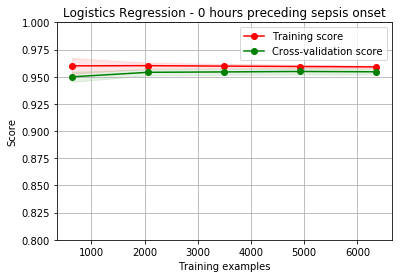

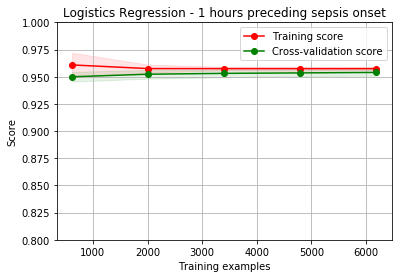

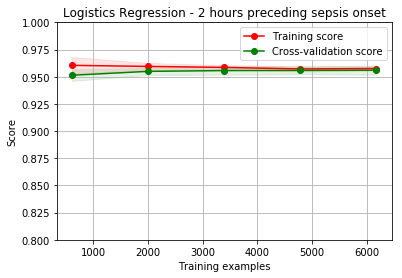

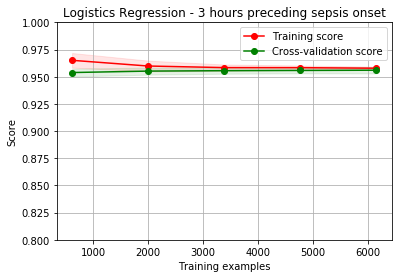

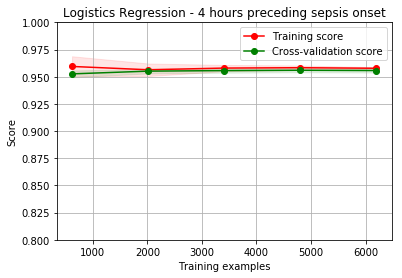

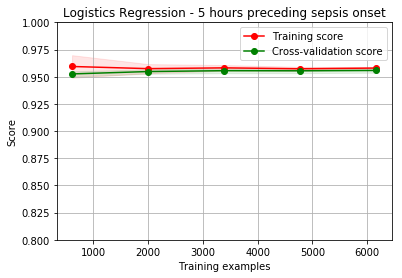

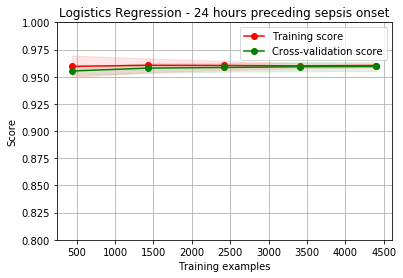

In [3]:
for h in list_hours:
    # STEP 1: Load * hour preceding sepsis onset
    h_folder = 'H'+str(h)
    input_data = pd.concat(map(pd.read_csv, glob.glob(os.path.abspath(os.path.join(INPUT_DATA_path, h_folder,  '*.csv')))))
    
    # STEP 2.1: Generate X and Y from source data
    Y = input_data.sepsis
    X = input_data.iloc[:, 2:-1]
    
    plt = plot_learning_curve(LogisticRegression(), "Logistics Regression "+ "- " + str(h) + " hours preceding sepsis onset", 
                        X, Y, ylim=(0.8, 1), cv=cv, n_jobs=4)

    plt.show()

### Step 3: Run different prediction window data on Neural Network

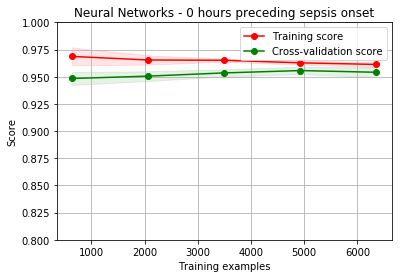

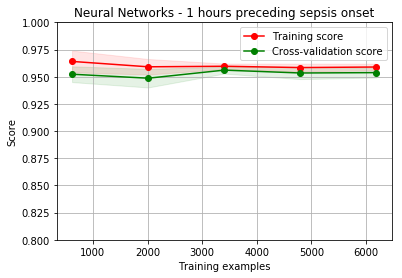

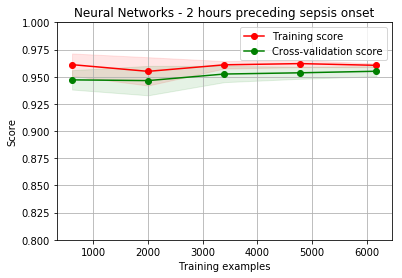

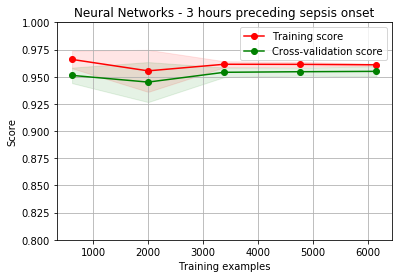

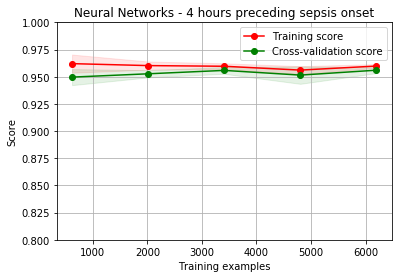

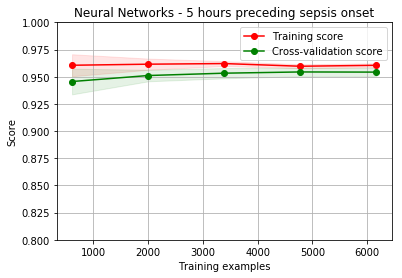

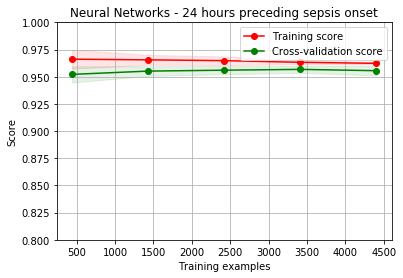

In [4]:
for h in list_hours:
    # STEP 1: Load * hour preceding sepsis onset
    h_folder = 'H'+str(h)
    input_data = pd.concat(map(pd.read_csv, glob.glob(os.path.abspath(os.path.join(INPUT_DATA_path, h_folder,  '*.csv')))))
    
    # STEP 2.1: Generate X and Y from source data
    Y = input_data.sepsis
    X = input_data.iloc[:, 2:-1]
    
    plt = plot_learning_curve(MLPClassifier(), "Neural Networks "+ "- " + str(h) + " hours preceding sepsis onset", 
                        X, Y, ylim=(0.8, 1), cv=cv, n_jobs=4)

    plt.show()

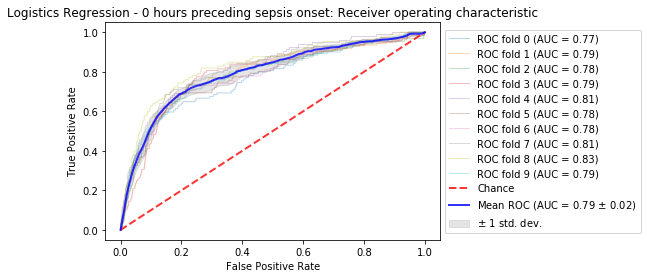

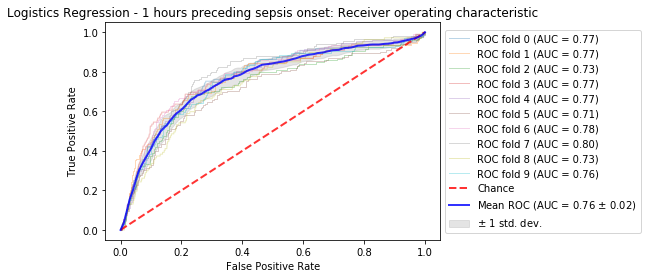

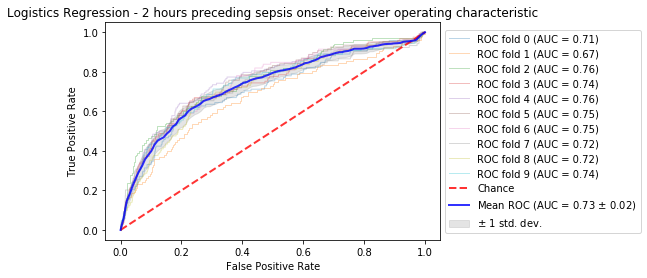

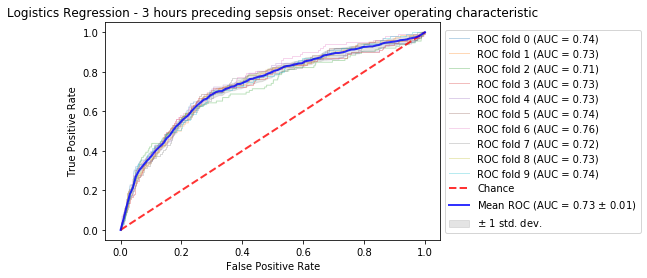

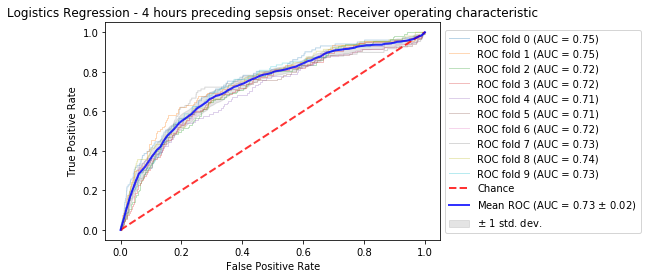

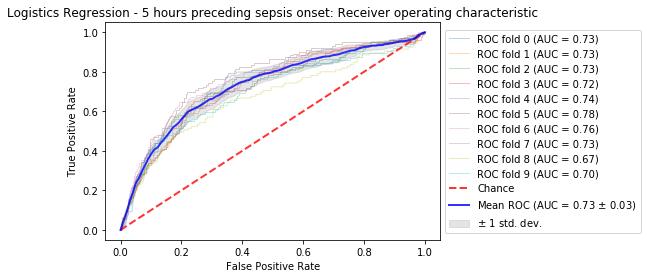

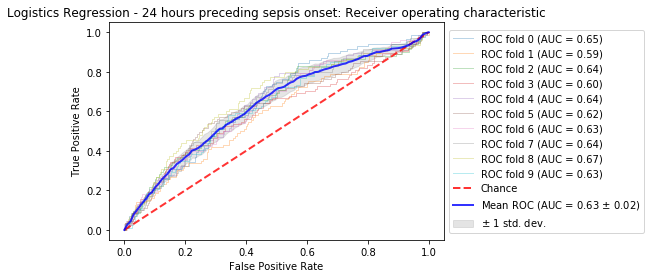

In [5]:
all_mean_tpr = []
all_mean_auc = []
all_std_auc = []
for h in list_hours:
    # STEP 1: Load * hour preceding sepsis onset
    h_folder = 'H'+str(h)
    input_data = pd.concat(map(pd.read_csv, glob.glob(os.path.abspath(os.path.join(INPUT_DATA_path, h_folder,  '*.csv')))))
    
    # STEP 2.1: Generate X and Y from source data
    Y = input_data.sepsis
    X = input_data.iloc[:, 2:-1]
    
    [plt, mean_tpr, mean_auc, std_auc] = plot_roc(LogisticRegression(), 
                                                  "Logistics Regression "+"- " + str(h) + " hours preceding sepsis onset", 
                                                  X, Y, cv)
    
    all_mean_tpr.append(mean_tpr)
    all_mean_auc.append(mean_auc)
    all_std_auc.append(std_auc)
    plt.show()

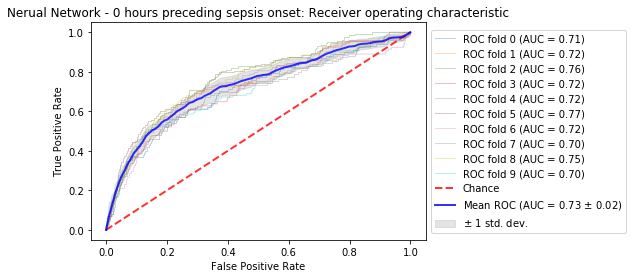

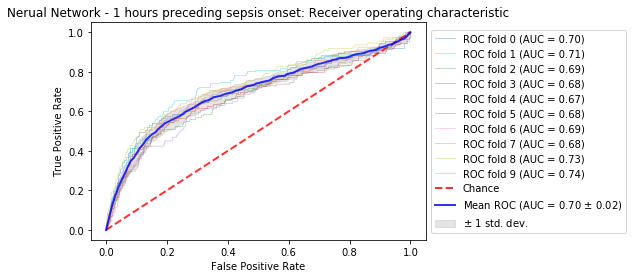

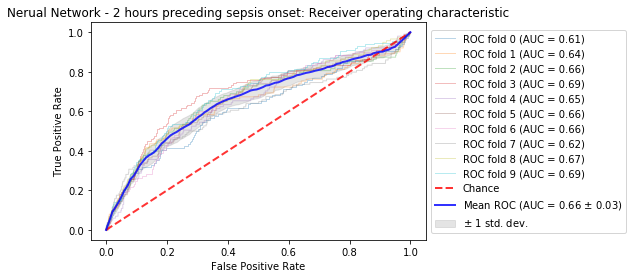

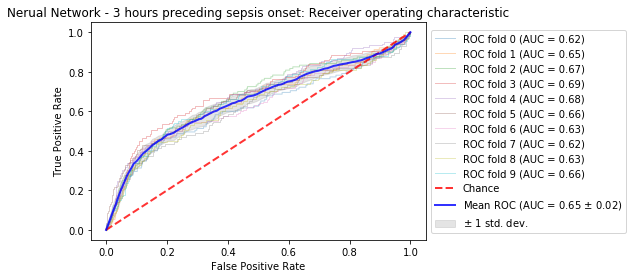

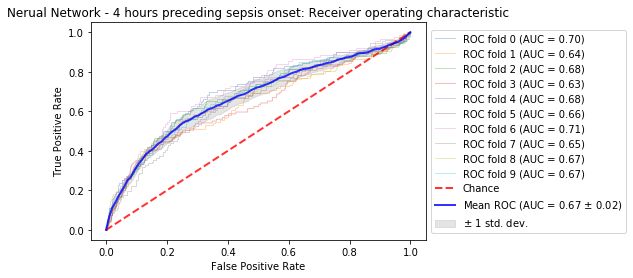

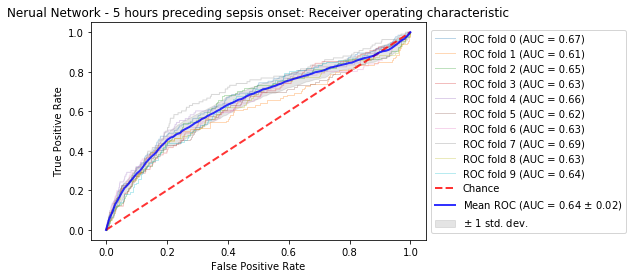

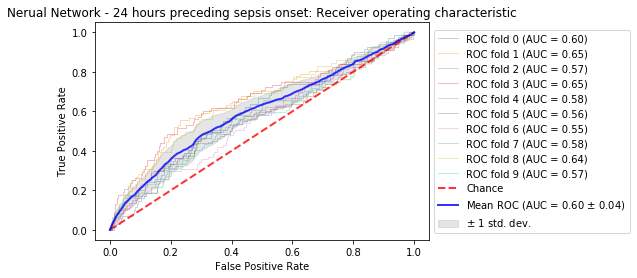

In [6]:
all_mean_tpr_NN = []
all_mean_auc_NN = []
all_std_auc_NN = []
for h in list_hours:
    # STEP 1: Load * hour preceding sepsis onset
    h_folder = 'H'+str(h)
    input_data = pd.concat(map(pd.read_csv, glob.glob(os.path.abspath(os.path.join(INPUT_DATA_path, h_folder,  '*.csv')))))
    
    # STEP 2.1: Generate X and Y from source data
    Y = input_data.sepsis
    X = input_data.iloc[:, 2:-1]
    
    [plt, mean_tpr, mean_auc, std_auc] = plot_roc(MLPClassifier(), 
                                                  "Nerual Network "+"- " + str(h) + " hours preceding sepsis onset", 
                                                  X, Y, cv)
    
    all_mean_tpr_NN.append(mean_tpr)
    all_mean_auc_NN.append(mean_auc)
    all_std_auc_NN.append(std_auc)
    plt.show()

### Step Final: Select Logistic Regression and Plot Figures to Compare Performanc on different hours preceding sepsis onset

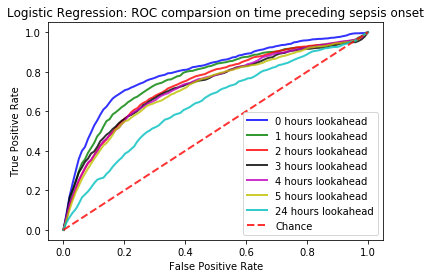

In [11]:
mean_fpr = np.linspace(0, 1, 100)
colors = ['b','g','r','k', 'm', 'y', 'c']
for index, h in enumerate(list_hours):    
    plt.plot(mean_fpr, all_mean_tpr[index], color=colors[index],
         label=r'%d hours lookahead' % h,
         lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression: ROC comparsion on time preceding sepsis onset')
plt.legend(loc='lower right')
#plt.legend(bbox_to_anchor=(1, 0.5))    
plt.show()

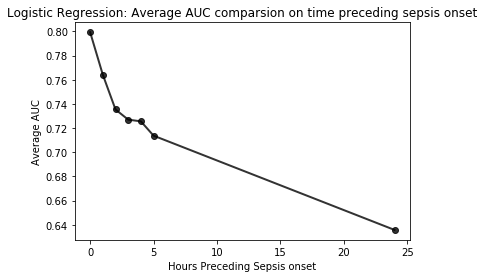

In [20]:
# for index, h in enumerate(list_hours):    
#     plt.plot(h, all_mean_auc[index], 'b*',
#          label=r'%d hours lookahead' % h,
#          lw=2, alpha=.8)
plt.plot(list_hours, all_mean_auc, 'ko-', lw=2, alpha=.8)
plt.xlabel('Hours Preceding Sepsis onset')
plt.ylabel('Average AUC')
plt.title('Logistic Regression: Average AUC comparsion on time preceding sepsis onset')
#plt.legend(loc='upper right')
#plt.legend(bbox_to_anchor=(1, 0.5))    
plt.show()

In [5]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle

input_data = pd.concat(map(pd.read_csv, glob.glob(os.path.abspath(os.path.join(INPUT_DATA_path, "H5",  '*.csv')))))

In [7]:
# train the model
Y = input_data.sepsis
X = input_data.iloc[:, 2:-1]
test_size = 0.3
seed = 6250
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
# Fit the model on 30%
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
# get the top 5 important features
feature_coef = model.coef_[0]
abs_weights = np.abs(feature_coef)
sorted_index = np.argsort(abs_weights)[::-1]
top_5 = sorted_index[:5]

top_5_feature = [ list(X)[i] for i in top_5]

print(top_5_feature)

['Ectopy_Frequency_2_Frequent', 'Heart_Rhythm_AV_Paced', "Ectopy_Type_2_PVC's", 'Heart_Rhythm_WAP_(Wandering_atrial_pacemaker)', 'Temperature_Site_Axillary']


In [23]:
tail_5 = sorted_index[-5:]

tail_5_feature = [ list(X)[i] for i in tail_5]

print(tail_5_feature) 

['Manual_Noninvasive_BP_Systolic', 'PAR_Respiration_N/A_-_pt_to_remain_on_ventilator', 'PAR_Remain_sedated_1', 'PAR_Consciousness_N/A_-_pt_to_remain_sedated', 'PAR_Oxygen_Saturation_Needs_O2_inhalation_to_maintain_O2_sat_>_90%']


In [16]:
# save the model to disk
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [17]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

0.953857791225416


In [21]:
# get the feature correlation
from sklearn.feature_selection import chi2
scores, pvalues = chi2(X_train, Y_train)
sum(pvalues < 0.01)

26

In [22]:
sorted_p = np.argsort(pvalues)
least_5 = sorted_p[:5]

least_5_p_feature = [ list(X)[i] for i in least_5]

print(least_5_p_feature)

['Arterial_BP_diastolic', 'ART_BP_Mean', 'ART_BP_Systolic', 'Arterial_BP_systolic', 'Arterial_BP_mean']
